# Analysis notebook: VAR2CSA

In [1]:
import numpy as np
from numpy.linalg import norm
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align, rms
import os
import glob
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns

# Figure 2 : 
MD Equilibration of VAR2CSA with a CSA 21mer sugar chain bound to it.

## RMSD

In [40]:
topdir = './MD-equil/'

diction = {
    "Time": [],
}

for i in range(1,11):
    rundir = topdir + str(i) + '/'
    
    # load universe
    u = mda.Universe(rundir + "run_pp.gro", rundir + "run_pp.xtc")
    u.trajectory[0]   # rewind trajectory
    
    sel = u.select_atoms("protein and name CA")
    xref0 = sel.positions - sel.center_of_mass()
    
    time_list = []
    rmsd_list = []
    
    for ts in enumerate(u.trajectory):
            
        time = u.trajectory.time / 1000
        time_list.append(time)
        
        rmsd = mda.analysis.rms.rmsd(sel.positions, xref0, center=True, superposition=True) 
        rmsd_list.append(rmsd)
        
    # add to dictionary
    if i == 1:
        diction["Time"] = time_list
        
    diction[str(i)] = rmsd_list    
            
rmsd = pd.DataFrame(diction)

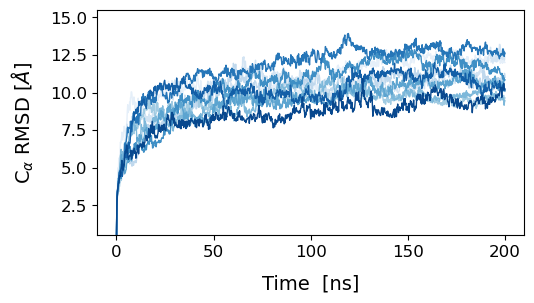

In [29]:
data = pd.DataFrame(diction)

plt.figure(figsize=(8.27*2/3,2.93))

ax = sns.lineplot(x='Time', y='value', hue='variable', 
             data=pd.melt(data, ['Time']), linewidth = 1, palette = 'Blues')

ax.set_xlabel(r"Time  [ns]",fontsize=14, labelpad=10)
ax.set_ylabel(ylabel = r"C$_\alpha$ RMSD [$\AA$]",fontsize=14, labelpad=10)
ax.set(ylim=(0.5, 15.5))
ax.tick_params(labelsize=12)
ax.legend([],[], frameon=False)

plt.savefig("/home/roessnra/Downloads/MD-equil-rmsd.svg")
#plt.savefig("/home/roessnra/Downloads/MD-equil-rmsd.png")

## Protein-sugar contacts

In [ ]:
%%bash
start_dir=$( pwd )

equil_dir=$( echo $start_dir/MD-equil)
cd $equil_dir

### analyse protein sugar contacts

outdir=$( echo $equil_dir/prot+sug_contacts)
mkdir $outdir

for run in  {1..10}
do
cd $run

    {
    echo 13 \| 14 
    echo q
    } | gmx make_ndx -f run_pp.gro -o tmp.ndx

    echo 1 15 | gmx mindist -f run_pp.xtc -s run.tpr -n tmp.ndx -d 0.45 -group -tu ns -on numcont_$run.xvg
    cp $equil_dir/$run/numcont_$run.xvg $outdir/numcont_$run.csv

    rm -f \#*\#

cd ..
done



In [6]:
# loads .csv files generated with gmx mindist
topdir = './MD-equil/prot+sug_contacts/'

diction = {
    "Time": [],
}

for i in range(1,11):
    
    data = np.loadtxt(topdir + "numcont_" + str(i) + ".csv", skiprows = 24)

    # add to dictionary
    if i == 1:
        diction["Time"] = data[:,0]

    diction[str(i)] = data[:,1] # number of contacts
contacts = pd.DataFrame(diction)

/tmp/ipykernel_61759/3143264913.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("/home/roessnra/Downloads/MD-equil-prot-sug.png")
./software/conda/envs/var2csa/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


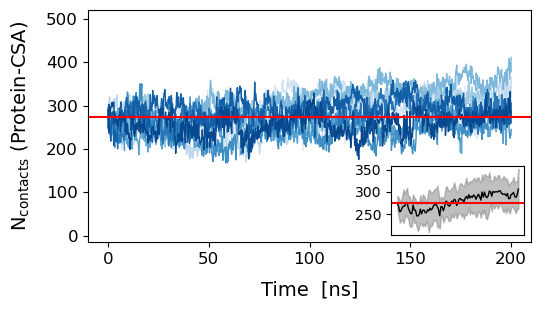

In [7]:
data = pd.DataFrame(diction)

fig, axes = plt.subplots(1, 1, figsize=(8.27*2/3,3.2), tight_layout=True, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

data=pd.melt(data, ['Time'])
plt.rcParams["text.usetex"] = False
ax = sns.lineplot(x='Time', y='value', hue='variable', 
             data=data, linewidth = 1, palette = 'Blues')

ax.set_xlabel(r"Time  [ns]",fontsize=14, labelpad=10)
ax.set_ylabel(r"${\rm N_{contacts}}$ (Protein-CSA)",fontsize=14, labelpad = 10)

ax.set(ylim=(-15, 520))
ax.tick_params(labelsize=12)

ax.axhline(np.mean(contacts.values[0,1:]), color='red')
ax.legend([],[], frameon=False)

# standard deviation vs. time
time = contacts.values[:,0]
arr_contacts = contacts.values[:,1:]
mean = np.mean(arr_contacts, axis=1)
stddev = np.std(arr_contacts, axis=1)

# Create an inset in the lower right corner
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="30%", height="30%", loc='lower right')
sns.lineplot(x=time[::10], y=mean[::10], color='black', label='mean', linewidth=1, ax=axins)
axins.fill_between(time[::10], mean[::10] - stddev[::10], mean[::10] + stddev[::10], color='grey', alpha=0.5)
axins.axhline(np.mean(contacts.values[0,1:]), color='red')
axins.set_xticks([])
axins.set_xticklabels([])

ax.legend([],[], frameon=False)
axins.legend([],[], frameon=False)
#plt.savefig("/home/roessnra/Downloads/MD-equil-prot-sug.svg")
plt.savefig("/home/roessnra/Downloads/MD-equil-prot-sug.png")

## CSA RMSF

In [ ]:
def RMSF_calculation(u):
    average = align.AverageStructure(u, u, select='not protein and not name H*', ref_frame=500).run()
    ref = average.universe
    aligner = align.AlignTraj(u, ref, select='not protein and not name H*', in_memory=True).run()
    csa = u.select_atoms('not protein and not name H*')
    RMSF = rms.RMSF(csa).run()
    return csa.resnums, RMSF.rmsf

topdir = './MD-equil/'

diction = {
    "Resids": [*range(1,22)],
}

for i in range(1,11):
    rundir = topdir + str(i) + '/'
    
    # load universe
    tmp = mda.Universe(rundir + "run_pp.gro", rundir + "run_pp.xtc")
    sel = tmp.select_atoms("all")
    
    with mda.Writer(rundir + 'tmp.xtc', sel.n_atoms) as w:
        for ts in tmp.trajectory[500:]:
            w.write(sel)
    
    u = mda.Universe(rundir + "run_pp.gro", rundir + "tmp.xtc")
    
    resid, rmsf = RMSF_calculation(u)
    
    # calculate mean for each residue 
    df = pd.DataFrame({'Resids':resid, 'RMSF':rmsf})
    
    df_grouped = df.groupby('Resids', as_index=False)['RMSF'].mean()
    
    # add to dictionary    
    diction[str(i)] = df_grouped['RMSF'].tolist() # rmsf values


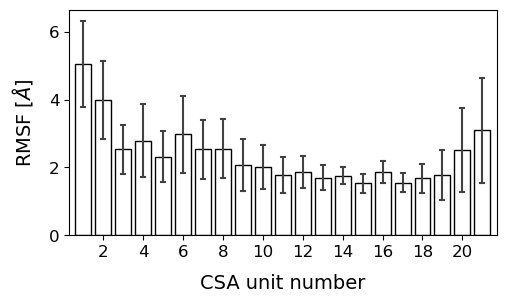

In [44]:
data = pd.DataFrame(diction)

plt.figure(figsize=(2/3*8.27,2.93))

#ax = sns.barplot(x='Resids', y='value', data=pd.melt(data, ['Resids']), 
#                 capsize = 0.2, errwidth = 1.5, errorbar = 'sd', palette=["#C0C0C0"]*10 + ["#5DFF5D"]*11)
ax = sns.barplot(x='Resids', y='value', data=pd.melt(data, ['Resids']), 
                 capsize = 0.2, errwidth = 1.5, errorbar = 'sd', linewidth=1, edgecolor=["Black"], facecolor=(0, 0, 0, 0))

ax.set_xlabel(r"CSA unit number",fontsize=14, labelpad=10)
ax.set_ylabel(ylabel = r"RMSF [$\AA$]",fontsize=14, labelpad=10)
ax.tick_params(labelsize=12)
ax.margins(x=0.015)
#ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels()[::2])
ax.legend([],[], frameon=False)

plt.xticks(np.arange(1, 21, 2))
plt.savefig("/home/roessnra/Downloads/MD-equil-rmsf.svg")
#plt.savefig("/home/roessnra/Downloads/MD-equil-rmsf.png")

# Figure 3 :
Force-induced opening of the VAR2CSA core region.

## Distance between N-/C-terminal subunit

In [52]:
topdir = './MD-pull/'

dico = {
    "Time": [],
}

for i in range(1,21):
    rundir = topdir + str(i) + '/'

        # load universe
    u = mda.Universe(rundir + "pull-nvt_pp.gro", rundir + "pull-run_pp.xtc")
    u.trajectory[0]   # rewind trajectory

    time_list = []
    dist_list = []
        
    nsel = u.select_atoms("resid 120")
    csel = u.select_atoms("resid 1663")
        
    for ts in enumerate(u.trajectory[:10100]):

        time = u.trajectory.time / 1000            
        dist = np.linalg.norm(csel.center_of_mass() - nsel.center_of_mass()) / 10 # in nm

        dist_list.append(dist)
        time_list.append(time)   

        # add to dictionary
    if i == 1:
        dico["Time"] = time_list

    dico[str(i)] = dist_list

df = pd.DataFrame(dico)
df.to_pickle(topdir + "dist_v2.pkl")

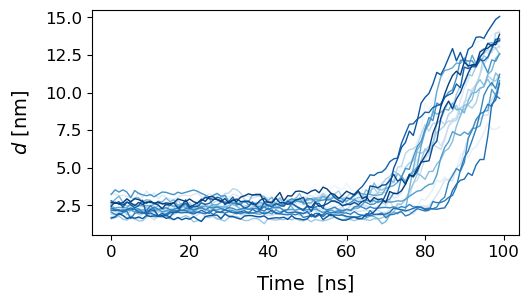

In [11]:
plt.figure(figsize=(2/3*8.27,2.93))

ax = sns.lineplot(x='Time', y='value', hue='variable', 
             data=pd.melt(df, ['Time']), linewidth = 1, palette = 'Blues')

ax.set_xlabel(r"Time  [ns]",fontsize=14, labelpad=10)
ax.set_ylabel(ylabel = "$d$ [nm]",fontsize=14, labelpad=10)
ax.tick_params(labelsize=12)
ax.legend([],[], frameon=False)
ax.set_ylim(0.5,15.5)

plt.savefig("/home/roessnra/Downloads/fig3-dist.svg")

## Protein-Sugar Contacts vs distance

In [ ]:
%%bash
pulldir=./MD-pull
outdir=$(echo $pulldir/prot+sug_contacts)
mkdir $outdir
cd $pulldir
pwd

for run in {1..20}
do
    cd $run
    pwd
    {
    echo 13 \| 14
    echo q
    } | gmx make_ndx -f pull-nvt_pp.gro -o tmp.ndx
    
    echo 1 15 | gmx mindist -f pull-run_pp.xtc -s pull-nvt_pp.gro -n tmp.ndx -d 0.45 -group -tu ns -on $outdir/numcont_$run.xvg
    cd ..
done    

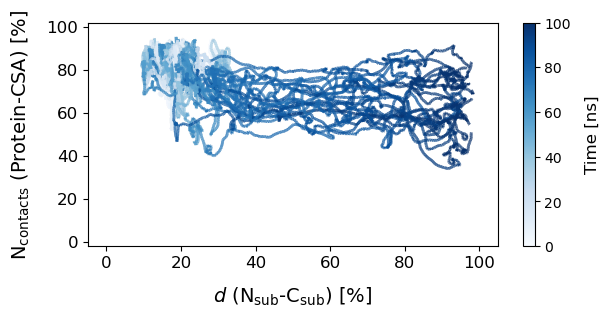

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# color map
pal = sns.color_palette("Reds", 100)
my_cmap = ListedColormap(sns.color_palette(pal).as_hex() + ["#000000"])

# load files generated with gmx sasa
df_dist = pd.read_pickle('./MD-pull/dist_v2.pkl')
contact_dir = './MD-pull/prot+sug_contacts/'

fig, ax = plt.subplots(1, 1, tight_layout=True, sharex=True, sharey=True, figsize=(8.27*0.75,3.2))

lst = []
for i in range(1,21):  
        contacts = np.loadtxt(contact_dir + "numcont_%d.xvg" %i, skiprows = 13, comments="@")[:10100]
        #arr_contacts = (contacts[:,1] - np.mean(contacts[:100,1])) / np.mean(contacts[:100,1])
        #arr_contacts = contacts[:,1] / np.mean(contacts[:100,1])
        arr_contacts = contacts[:,1] / np.max(contacts[:,1])
        
        dist = np.array(df_dist[str(i)])
        #arr_dist = (dist - np.mean(dist[:100])) / np.max(dist)
        arr_dist = dist / np.max(dist)
        
        arr_time = contacts[:,0] 
  
        # smooth time trace
        y = moving_average(arr_contacts, 100)*100
        x = moving_average(arr_dist, 100)*100
        time = arr_time[:len(x)]
        
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(time.min(), time.max())
        lc = LineCollection(segments, cmap="Blues", norm=norm)
        # Set the values used for colormapping
        lc.set_array(time)
        lc.set_linewidth(2)
        line = ax.add_collection(lc)

ax.set_xlim(-5,105)
ax.set_ylim(-2,102)
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0', '20', '40', '60', '80', '100'])
#ax.set_xlabel(r"${\rm N_{contacts}}$ (${\rm N_{sub}}$-${\rm C_{sub}}$) [%]",fontsize=14, labelpad = 10)
ax.set_xlabel(r"$d$ (${\rm N_{sub}}$-${\rm C_{sub}}$) [%]",fontsize=14, labelpad = 10)
ax.set_ylabel(r"${\rm N_{contacts}}$ (Protein-CSA) [%]",fontsize=14, labelpad = 10)

ax.tick_params(labelsize=12)
cbar = fig.colorbar(line, ax=ax)
cbar.set_label("Time [ns]",fontsize=12, labelpad = 10)
#cax = fig.add_axes([0.62, 0.35, 0.3, 0.02])  # [left, bottom, width, height]
#cbar = fig.colorbar(line, cax=cax, orientation='horizontal')
#cbar.ax.set_title("Time [ns]", fontsize=12)
#cbar.ax.tick_params(labelsize=8)

#plt.savefig("/home/roessnra/Downloads/Distance_vs_contacts.svg")
plt.savefig("/home/roessnra/Downloads/Distance_vs_contacts.png", dpi=500)

## RMSD
We calculate the RMSD protein and the C-/N-terminal region individually. <br> 
- N-ter = resid 1-959 (NTS, DBL1x, ID1, DBL2X)
- C-ter = resid 960-1953 (ID2, DBL3X, DBL4E, ID3)

In [ ]:
topdir = './MD-pull/'

diction = {
    "Time": [],
}

for i in range(1,21):
    rundir = topdir + str(i) + '/'

    # load universe
    u = mda.Universe(rundir + "pull-nvt_pp.gro", rundir + "pull-run_pp.xtc")
    u.trajectory[0]   # rewind trajectory

    sel = u.select_atoms("protein and name CA and resid 30-959")
    xref0 = sel.positions - sel.center_of_mass()

    time_list = []
    rmsd_list = []

    for ts in enumerate(u.trajectory[:10000:100]):

        time = u.trajectory.time / 1000
        time_list.append(time)

        rmsd = mda.analysis.rms.rmsd(sel.positions, xref0, center=True, superposition=True) 
        rmsd_list.append(rmsd)

    # add to dictionary
    if i == 2:
        diction["Time"] = time_list

    diction[str(i)] = rmsd_list

df_Nter = pd.DataFrame(diction)

In [ ]:
topdir = './MD-pull/'

diction = {
    "Time": [],
}

for i in range(1,21):
    rundir = topdir + str(i) + '/'

    # load universe
    u = mda.Universe(rundir + "pull-nvt_pp.gro", rundir + "pull-run_pp.xtc")
    u.trajectory[0]   # rewind trajectory

    sel = u.select_atoms("protein and name CA and resid 965-1930")
    xref0 = sel.positions - sel.center_of_mass()

    time_list = []
    rmsd_list = []

    for ts in enumerate(u.trajectory[:10000:100]):

        time = u.trajectory.time / 1000
        time_list.append(time)

        rmsd = mda.analysis.rms.rmsd(sel.positions, xref0, center=True, superposition=True) 
        rmsd_list.append(rmsd)

    # add to dictionary
    if i == 2:
        diction["Time"] = time_list

    diction[str(i)] = rmsd_list

df_Cter = pd.DataFrame(diction)

In [ ]:
topdir = './MD-pull/'

dico = {
    "Time": [],
}

for i in range(1,21):
    rundir = topdir + str(i) + '/'

    # load universe
    u = mda.Universe(rundir + "pull-nvt_pp.gro", rundir + "pull-run_pp.xtc")
    u.trajectory[0]   # rewind trajectory

    sel = u.select_atoms("protein and name CA")
    xref0 = sel.positions - sel.center_of_mass()

    time_list = []
    rmsd_list = []

    for ts in enumerate(u.trajectory[:10000:100]):

        time = u.trajectory.time / 1000
        time_list.append(time)

        rmsd = mda.analysis.rms.rmsd(sel.positions, xref0, center=True, superposition=True) 
        rmsd_list.append(rmsd)

    # add to dictionary
    if i == 1:
        dico["Time"] = time_list

    dico[str(i)] = rmsd_list

df_rmsd = pd.DataFrame(dico)

80


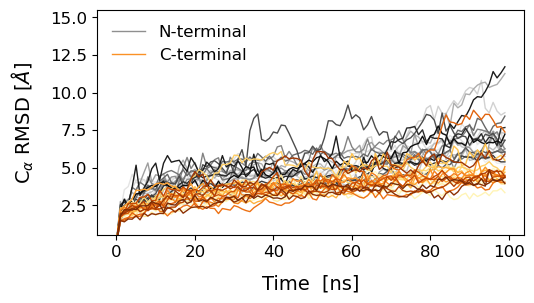

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(2/3*8.27,2.93))
plt.subplots_adjust(wspace=0.02)

sns.lineplot(ax = ax, x='Time', y='value', hue='variable', 
             data=pd.melt(df_Nter, ['Time']), linewidth = 1, palette = 'Greys', label='N-terminal')
sns.lineplot(ax = ax, x='Time', y='value', hue='variable', 
             data=pd.melt(df_Cter, ['Time']), linewidth = 1, palette = 'YlOrBr', label='C-terminal')
ax.set_xlabel(r"Time  [ns]",fontsize=14, labelpad=10)
ax.set_ylabel(ylabel = r"C$_\alpha$ RMSD [$\AA$]",fontsize=14, labelpad=10)

ax.tick_params(labelsize=12)
ax.legend([],[], frameon=False)
h, l = ax.get_legend_handles_labels()
ax.legend([h[10], h[50]], ["N-terminal", "C-terminal"], loc='upper left', bbox_to_anchor=(0, 1), fontsize = 12, frameon=False)
print(len(h))
ax.set_ylim(0.5,15.5)
plt.savefig("/home/roessnra/Downloads/fig3-rmsd.svg")

# Figure 4 :
Pulling orientation of VAR2CSA and protein–sugar electrostatic interactions an explain the opening of the tethered VAR2CSA core region.

## Opening angle and CSA detachment angle

In [ ]:
def get_angle(vec1, vec2):
    unit_vec1 = vec1 / np.linalg.norm(vec1)
    unit_vec2 = vec2 / np.linalg.norm(vec2)

    dot_product = np.dot(unit_vec1, unit_vec2)
    angle = np.arccos(dot_product)
    
    return np.rad2deg(angle)

topdir = './MD-pull/'

detachment = {}
opening = {}

#for i in range(1,21):
for i in range(1,21):
    rundir = topdir + str(i) + '/'

    # load universe
    u = mda.Universe(rundir + "pull-nvt_pp.gro", rundir + "pull-run_pp.xtc")
    u.trajectory[0]   # rewind trajectory
       
    time_list = []
    detach_list = []
    open_list = []

    for ts in enumerate(u.trajectory[:10000:100]):

        time = u.trajectory.time / 1000
        time_list.append(time)
        
        p1 = u.select_atoms("resid 1953 and name CA").center_of_mass()
        p2 = u.select_atoms("resid 1 and resname BGLCA").center_of_mass()
        vec_pull = p2 - p1
        
        p3 = u.select_atoms("resid 11 and resname BGLCA").center_of_mass()
        vec_sug = p2 - p3  
        
        detach_list.append(get_angle(vec_pull, vec_sug))
        
        p4 = u.select_atoms("resid 1891 and name CA").center_of_mass()
        p5 = u.select_atoms("resid 1744 and name CA").center_of_mass()
        vec_int = p5 - p4 
        
        open_list.append(get_angle(vec_pull, vec_int))

    # add to dictionary
    if i == 1:
        detachment["Time"] = time_list
        opening["Time"] = time_list

    detachment[str(i)] = detach_list
    opening[str(i)] = open_list
    
df_detach = pd.DataFrame(detachment)
df_open = pd.DataFrame(opening)


19.811539396589673 12.34603786994885
51.29689421755584 10.75151834514132
[<BarContainer object of 1 artists>, <BarContainer object of 25 artists>, <BarContainer object of 18 artists>]


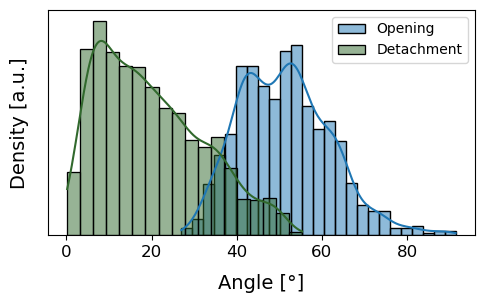

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(2/3*8.27,2.93), tight_layout=False)
plt.subplots_adjust(wspace=0.02)

arr_detach = np.empty([0,])
arr_open = np.empty([0,])
for i in range(1,21):
    a = np.array(df_detach[str(i)])[:80] 
    arr_detach = np.hstack((arr_detach, a))
    b = np.array(df_open[str(i)])[:80]
    arr_open = np.hstack((arr_open, b))

print(np.mean(arr_detach), np.std(arr_detach))
print(np.mean(arr_open), np.std(arr_open))
sns.histplot(arr_open, fill =True, kde=True, label="Opening")
sns.histplot(arr_detach, fill =True, kde=True, label="Detachment", color="#31692D")


#sns.kdeplot(arr_detach, fill =True, bw_adjust=2, label="Detachment")
#sns.kdeplot(arr_open, fill =True, bw_adjust=2, label="Opening")

ax.set_xlabel(xlabel = "Angle [°]", fontsize=14, labelpad=10)
ax.set_ylabel(ylabel = r"Density [a.u.]",fontsize=14, labelpad=10)
ax.tick_params(labelsize=12)
ax.set_yticks([])

h, l = ax.get_legend_handles_labels()
print(h)
ax.legend([h[1], h[2]], [l[1], l[2]], loc="upper right", fontsize=10)


plt.savefig("/home/roessnra/Downloads/fig4-orientation-hist.svg")

## Electrostatic Potentials
We calculate Lennard-Jones, Coulomb and total electrostatic potential between CSA/protein and N-/C-terminal region. <br> 
- N-ter = resid 1-959 (NTS, DBL1x, ID1, DBL2X)
- C-ter = resid 960-1953 (ID2, DBL3X, DBL4E, ID3)

In [ ]:
%%bash
# create index groups
cd MD-equil

for run in {1..10}
do
    { 
    echo 13 \| 14
    echo name 18 Sugar
    echo 1 \& r 1-959
    echo name 19 Nter
    echo 1 \& r 960-1953
    echo name 20 Cter
    echo q 
    } | gmx make_ndx -f $run/run.gro -o $run/energy.ndx
done

In [15]:
!cp run-equil.mdp energy_sugar.mdp

with open("energy_sugar.mdp", "a") as f:
    f.write("\n")
    f.write("energygrps = Protein Sugar")
    
!cp run-equil.mdp energy_subunits.mdp

with open("energy_subunits.mdp", "a") as f:
    f.write("\n")
    f.write("energygrps = Nter Cter")

In [ ]:
%%bash
# compute energies
cd MD-equil
for run in {1..10}
do
    cd $run
    gmx grompp -f ../../energy_sugar.mdp -c run.gro -p ../topol.top -n energy.ndx -o topol_sugar.tpr
    #gmx mdrun -s topol_sugar.tpr -rerun run.xtc -e rerun_sugar.edr
    
    gmx grompp -f ../../energy_subunits.mdp -c run.gro -p ../topol.top -n energy.ndx -o topol_subunits.tpr
    #gmx mdrun -s topol_subunits.tpr -rerun run.xtc -e rerun_subunits.edr
    cd ..
done

In [ ]:
%%bash
cd MD-equil
for run in {1..10}
do
    cd $run
    echo 21 22 0 | gmx energy -f rerun_sugar.edr -b 100000 -e 200000 -o energy_sugar.xvg
    echo 21 22 0 | gmx energy -f rerun_subunits.edr -b 100000 -e 200000 -o energy_subunits.xvg
    cd ..
done

In [3]:
topdir = './MD-equil/'

Coul_sugar = []
LJ_sugar = []
Coul_su = []
LJ_su = []


for i in range(1,11):
    
    if i == 5:
        pass
    else:    
        data = np.loadtxt(topdir + "%d/energy_sugar.xvg" %i, skiprows = 25)
        Coul_sugar.append(data[:,1].tolist())
        LJ_sugar.append(data[:,2].tolist())

        data = np.loadtxt(topdir + "%d/energy_subunits.xvg" %i, skiprows = 25)
        Coul_su.append(data[:,1].tolist())
        LJ_su.append(data[:,2].tolist())
    
def flatten(l):
    return [item for sublist in l for item in sublist]

dico = {
    "Coul_sugar" : flatten(Coul_sugar),
    "LJ_sugar" : flatten(LJ_sugar),
    "Coul_su" : flatten(Coul_su),
    "LJ_su" : flatten(LJ_su),
}
df = pd.DataFrame(dico)
df["Total_sugar"] = df["Coul_sugar"] + df["LJ_sugar"]
df["Total_su"] = df["Coul_su"] + df["LJ_su"]
df

,Coul_sugar,LJ_sugar,Coul_su,LJ_su,Total_sugar,Total_su
0,-2135.996338,-304.637238,-1059.737427,-443.167725,-2440.633576,-1502.905152
1,-1960.847046,-327.449341,-1095.613647,-430.843231,-2288.296387,-1526.456878
2,-2273.811768,-326.391693,-1147.508057,-339.565674,-2600.203461,-1487.073731
3,-2314.324219,-301.757416,-1175.841797,-467.755341,-2616.081635,-1643.597138
4,-2316.067627,-307.929352,-1167.435181,-446.417938,-2623.996979,-1613.853119
...,...,...,...,...,...,...
4504,-1786.619141,-378.531677,-383.923676,-162.701294,-2165.150818,-546.624970
4505,-1861.382935,-423.190979,-494.078400,-206.343628,-2284.573914,-700.422028
4506,-1846.965332,-403.652344,-686.091919,-155.556534,-2250.617676,-841.648453
4507,-1796.112793,-363.467438,-531.830139,-155.225189,-2159.580231,-687.055328


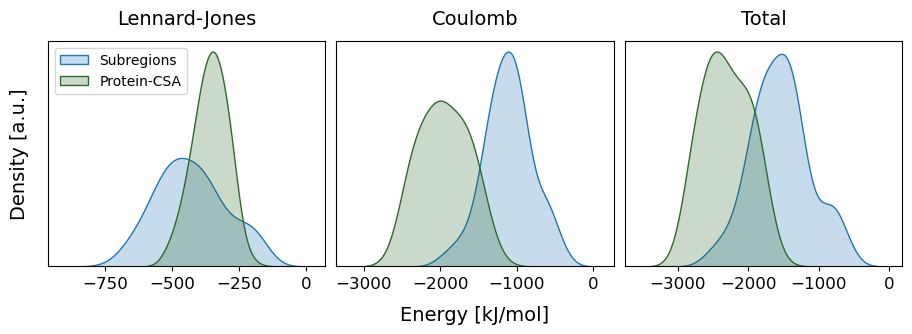

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(4/3*8.27,2.93), tight_layout=False)
plt.subplots_adjust(wspace=0.04)

sns.kdeplot(df, ax=ax[0], x="LJ_su", fill =True, bw_adjust=2, label="Subregions")
sns.kdeplot(df, ax=ax[0], x="LJ_sugar", fill =True, bw_adjust=2, label="Protein-CSA", color="#31692D")
ax[0].legend(loc="upper left", fontsize=10)
ax[0].set_title("Lennard-Jones",fontsize=14, pad=12)
ax[0].set_xlabel(xlabel = "")
ax[0].set_ylabel(ylabel = r"Density [a.u.]",fontsize=14, labelpad=10)
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([])

sns.kdeplot(df, ax=ax[1], x="Coul_su", fill =True, bw_adjust=2, label="Subregions")
sns.kdeplot(df, ax=ax[1], x="Coul_sugar", fill =True, bw_adjust=2, label="Protein-CSA", color="#31692D")
ax[1].set_title("Coulomb",fontsize=14, pad=12)
ax[1].set_xlabel(xlabel = "Energy [kJ/mol]",fontsize=14, labelpad=10)
ax[1].set_ylabel(ylabel = "")
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([])

sns.kdeplot(df, ax=ax[2], x="Total_su", fill =True, bw_adjust=2, label="Subregions")
sns.kdeplot(df, ax=ax[2], x="Total_sugar", fill =True, bw_adjust=2, label="Protein-CSA", color="#31692D")
ax[2].set_title("Total",fontsize=14, pad=12)
ax[2].set_xlabel(xlabel = "")
ax[2].set_ylabel(ylabel = "")
ax[2].tick_params(labelsize=12)
ax[2].set_yticks([])
#ax[2].set(xlim=(-3999, 0))

plt.savefig("/home/roessnra/Downloads/MD-equil-electrostatics.svg")
#plt.savefig("/home/roessnra/Downloads/MD-equil-electrostatics.png")

## Hydrygen bonds: VAR2CSA - CSA

In [86]:
%%bash
# concatenate trajectories
dir=./MD-equil
cd $ dir
gmx trjcat -f ?/run_pp.xtc ??/run_pp.xtc -dt 1000 -b 100000 -o run_pp_concat.xtc

Hydrogen bonds:

In [ ]:
# get all protein resids that are around 5 of sugar
topdir = './MD-equil/'

u = mda.Universe(topdir + "1/run_pp.gro", topdir + "run_pp_concat.xtc")
u.trajectory[0]   # rewind trajectory

lst=[]
for ts in u.trajectory:
    # Define the selections
    sel = u.select_atoms("protein and resname SER THR TYR TRP ASN GLN LYS ARG HSD ASP GLU and around 5 (resname BGLCA or resname BGALN)")
    resids = np.unique(sel.resids)
    lst.append(resids)
        
resids = np.unique(np.concatenate(lst))
print(' '.join(map(str, resids)))

In [ ]:
%%bash
indir=./MD-equil
outdir=$(echo $indir/hbonds)
mkdir $outdir
cd $indir
pwd

resids=( 35 36 37 39 42 44 45 47 48 52 54 56 57 63 64 67 68 103 132 136 140 262 263 508 513 553 554 555 556 557 558 560 561 562 564 567 572 573 576 695 696 700 816 821 824 828 829 831 832 835 836 838 839 842 845 846 847 848 849 852 853 854 858 859 860 861 862 865 866 918 919 921 922 933 1674 1678 1735 1738 1739 1740 1741 1743 1781 1782 1787 1880 1885 1888 1889 1890 1892 1896 1898 1899 )
for resid in "${resids[@]}"
do
    pwd
    {
    echo 1 \& r $resid 
    echo 13 \| 14 
    echo q
    } | gmx make_ndx -f 1/run_pp.gro -o tmp.ndx
    
    echo 15 16 | gmx hbond -f run_pp_concat.xtc -s 1/run_pp.tpr -n tmp.ndx -tu ns -dt 1 -num $outdir/resid_$resid.xvg
    rm \#*\#
done    

Add ion bonds:

In [ ]:
# get all protein resids that are around 5 of sugar
topdir = './MD-equil/'

u = mda.Universe(topdir + "1/run_pp.gro", topdir + "run_pp_concat.xtc")
u.trajectory[0]   # rewind trajectory

lst=[]
for ts in u.trajectory:
    # Define the selections
    sel = u.select_atoms("protein and resname ARG HSD LYS and around 5 (resname BGLCA or resname BGALN)")
    resids = np.unique(sel.resids)
    lst.append(resids)
    
    
resids = np.unique(np.concatenate(lst))
print(' '.join(map(str, resids)))

In [ ]:
u = mda.Universe(topdir + "1/run_pp.gro")
sugar = u.select_atoms("(resname BGALN and name O4 OS42 OS43 OS44) or (resname BGLCA and name O61 O62)")
lst = [i+1 for i in sugar.indices]
print(' '.join(map(str, lst)))

In [ ]:
%%bash
indir=./MD-equil
outdir=$(echo $indir/hbonds)
mkdir $outdir
cd $indir
pwd

resids=( 47 48 52 57 68 103 132 553 556 561 562 572 816 828 829 835 836 839 845 846 848 849 853 919 922 1674 1739 1743 1782 1787 1889 1890 )
for resid in "${resids[@]}"
do
    pwd
    {
    echo 1 \& r $resid 
    echo 13 \| 14 & a 31207 31208 31229 31231 31232 31233 31256 31257 31278 31280 31281 31282 31305 31306 31327 31329 31330 31331 31354 31355 31376 31378 31379 31380 31403 31404 31425 31427 31428 31429 31452 31453 31474 31476 31477 31478 31501 31502 31523 31525 31526 31527 31550 31551 31572 31574 31575 31576 31599 31600 31621 31623 31624 31625 31648 31649 31670 31672 31673 31674 31697 31698
    echo q
    } | gmx make_ndx -f 1/run_pp.gro -o tmp.ndx
    
    echo 15 16 | gmx hbond -f run_pp_concat.xtc -s 1/run_pp.tpr -n tmp.ndx -tu ns -dt 1 -num $outdir/ionbond_resid_$resid.xvg
    rm \#*\#
done    

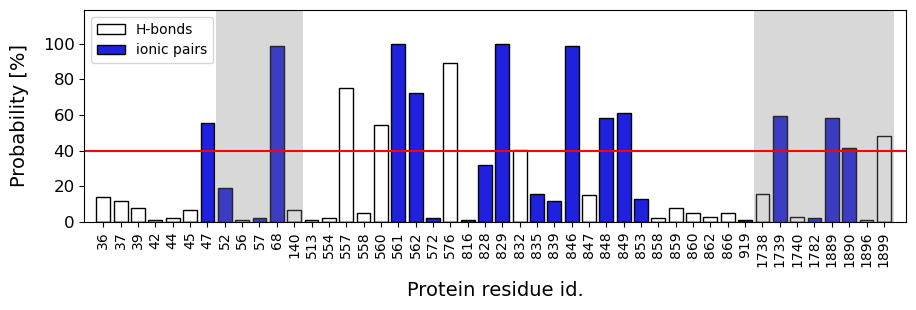

In [2]:
topdir="./MD-equil/hbonds/"

fig, ax = plt.subplots(1, 1, figsize=(8.27*1.12,3.2), tight_layout=True, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

resids = [35, 36, 37, 39, 42, 44, 45, 47, 48, 52, 54, 56, 57, 63, 64, 67, 68, 103, 132, 136, 140, 262, 263, 508, 513, 553, 554, 555, 556, 557, 558, 560, 561, 562, 564, 567, 572, 573, 576, 695, 696, 700, 816, 821, 824, 828, 829, 831, 832, 835, 836, 838, 839, 842, 845, 846, 847, 848, 849, 852, 853, 854, 858, 859, 860, 861, 862, 865, 866, 918, 919, 921, 922, 933, 1674, 1678, 1735, 1738, 1739, 1740, 1741, 1743, 1781, 1782, 1787, 1880, 1885, 1888, 1889, 1890, 1892, 1896, 1898, 1899]

contact_resids = []
contact_perc_hbond = []
contact_perc_ibond = []
for resid in resids:
    data = np.loadtxt(topdir + "resid_%d.xvg" %resid, comments=['#','@'])  
    contacts = np.count_nonzero(data[:,1]) # count frames when residue formed a hydrogen bond
    if contacts != 0:
        contact_resids.append(resid)
        contact_perc_hbond.append(contacts/len(data[:,1])*100) # percentage of frames residue formed h-bond with sugar
    
        if os.path.exists(topdir + "ionbond_resid_%d.xvg" %resid):
            data = np.loadtxt(topdir + "ionbond_resid_%d.xvg" %resid, comments=['#','@'])
            contacts = np.count_nonzero(data[:,1]) # count frames when residue formed an ion bond
            if contacts != 0:
                contact_perc_ibond.append(contacts/len(data[:,1])*100) # percentage of frames residue formed h-bond with sugar      
            else:
                contact_perc_ibond.append(0)
        else:
            contact_perc_ibond.append(0) 

        
df = pd.DataFrame()
df['Resids'] = contact_resids 
df['ibond'] = contact_perc_ibond
df['add_hbond'] = np.array(contact_perc_hbond) - np.array(contact_perc_ibond)
df = df.melt('Resids', var_name='Type', value_name='Value')
df = df.sort_values(by='Type')
#ax = sns.barplot(x='Resid', y='Value', hue='Type', data=df, linewidth=1, edgecolor=["Black"], facecolor=(0, 0, 0, 0))
pal = ["white", "blue"]
ax = sns.barplot(x='Resids', y='Value', hue='Type', data=df, linewidth=1, edgecolor=["black"], dodge=False, palette=pal)

ax.set_xlabel(r"Protein residue id.",fontsize=14, labelpad=10)
ax.set_ylabel(ylabel = r"Probability [%]",fontsize=14, labelpad=10)
ax.axhline(40, color='red')
ax.tick_params(labelsize=12)
ax.margins(x=0.015)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=10)
ax.set_ylim(0,119)
plt.axvspan(6.5, 11.5, facecolor='gray', alpha=0.3)
plt.axvspan(37.5, 45.6, facecolor='gray', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['H-bonds', 'ionic pairs'], bbox_to_anchor=(0, 1), loc='upper left')

plt.savefig("/home/roessnra/Downloads/MD-hbonds-per-resid_v2.svg")
plt.savefig("/home/roessnra/Downloads/MD-hbonds-per-resid_v2.png")

# Figure 6:
Force exposes two cryptic secondary CSA sugar binding sites.

## SASA vs distance between Subunits

SASA:

In [ ]:
%%bash
### compute sasa docked binding sites
pulldir=./MD-pull
outdir=$(echo $pulldir/sasa_docked)
mkdir $outdir
cd $pulldir
pwd

for run in {1..20}
do
    cd $run
    {
    echo 1 \& r 787  788  910  911  912  913  915  947  949  952  953  956  958  960 968  969 1050 1052 1086 1087 1599 1860 1863 1868
    echo name 15 minor
    echo 1 \& r 1776 1780 1781 1782 1784 1785 1787 1877 1879 1889 1890 1896 1898 1899 1900
    echo name 16 dbl4
    echo 1 \| 13 \| 14
    echo name 17 prot_sug
    echo q
    } | gmx make_ndx -f pull-nvt_pp.gro -o tmp.ndx
    
    {
    echo "prot_sug"
    echo "minor"
    } | gmx sasa -f pull-run_pp.xtc -s pull-nvt_pp.gro -dt 1000 -n tmp.ndx -surface -output -probe 0.5  -o $outdir/minor-binding-site-probe-05nm-$run.xvg
    
    {
    echo "prot_sug"
    echo "dbl4"
    } | gmx sasa -f pull-run_pp.xtc -s pull-nvt_pp.gro -dt 1000 -n tmp.ndx -surface -output -probe 0.5 -o $outdir/dbl4-major-binding-site-probe-05nm-$run.xvg

    cd ..
done    

In [ ]:
Distance between subunits:

In [ ]:
topdir = './MD-pull/'

dico = {
    "Time": [],
}

for i in range(1,21):
    rundir = topdir + str(i) + '/'

        # load universe
    u = mda.Universe(rundir + "pull-nvt_pp.gro", rundir + "pull-run_pp.xtc")
    u.trajectory[0]   # rewind trajectory

    time_list = []
    dist_list = []
        
    nsel = u.select_atoms("resid 120")
    csel = u.select_atoms("resid 1663")
        
    for ts in enumerate(u.trajectory[:10100]):

        time = u.trajectory.time / 1000            
        dist = np.linalg.norm(csel.center_of_mass() - nsel.center_of_mass()) / 10 # in nm

        dist_list.append(dist)
        time_list.append(time)   

        # add to dictionary
    if i == 1:
        dico["Time"] = time_list

    dico[str(i)] = dist_list

df = pd.DataFrame(dico)
df.to_pickle(topdir + "dist_v2.pkl")

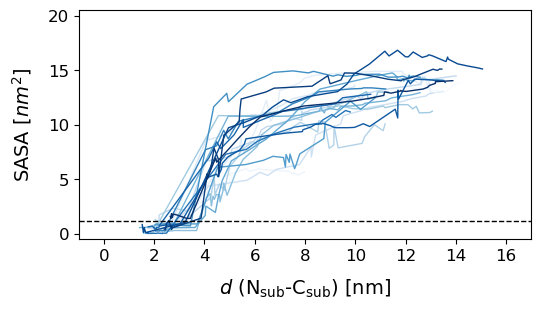

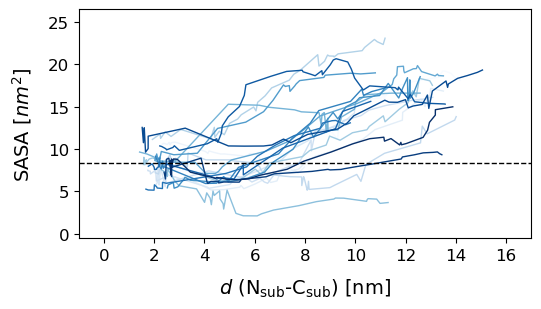

In [51]:
import scipy.ndimage
topdir = "./MD-pull/sasa_docked/"
sites = ["dbl4-major-binding-site", "minor-binding-site"]

df_distance = pd.read_pickle('./MD-pull/dist_v2.pkl')

for i, site in enumerate(sites):
    lst=[]
    lst_mean=[]
    for run in range(1,21):
        data = np.loadtxt(topdir + "%s-probe-05nm-%d.xvg" %(site, run), comments=["@","#"])
        sasa = data[:100,2]
        lst_mean.append(np.mean(data[:80,2]))
        arr_distance = df_distance[str(run)].values
        distance = arr_distance[:10000:100]
        
        df = pd.DataFrame()
        # distance < 4
        distance_values = distance[distance < 4]
        filtered_indices = np.where(distance < 4)[0]
        
        sasa_values = sasa[filtered_indices]
        
        df["sasa"] = sasa_values[::10]
        sigma = 2.0  # Adjust the value of sigma for stronger/weaker smoothing
        df["sasa_smooth"] = scipy.ndimage.gaussian_filter1d(df['sasa'], sigma)
        df["distance"] = distance_values[::10]
        df["replica"] = run
        
        lst.append(df)
        
        df = pd.DataFrame()
        # distance < 4
        distance_values = distance[distance > 4]
        filtered_indices = np.where(distance > 4)[0]
        
        sasa_values = sasa[filtered_indices]
        
        df["sasa"] = sasa_values
        sigma = 2.0  # Adjust the value of sigma for stronger/weaker smoothing
        df["sasa_smooth"] = scipy.ndimage.gaussian_filter1d(df['sasa'], sigma)
        df["distance"] = distance_values
        df["replica"] = run
        
        lst.append(df)
        
    
    df = pd.concat(lst)
    plt.figure(figsize=(8.27*2/3,3.2))
   
    ax = sns.lineplot(x='distance', y='sasa_smooth', hue='replica', palette="Blues", data=df, linewidth = 1)
    # mean before opening
    sasa_mean = np.mean(lst_mean)
    ax.axhline(y=sasa_mean, color='black', linestyle='--', linewidth = 1)
    
    ax.tick_params(labelsize=12)

    ax.legend([],[], frameon=False)
    ax.set_xlabel(r"$d$ (${\rm N_{sub}}$-${\rm C_{sub}}$) [nm]",fontsize=14, labelpad=10)
    
    if i == 0:
        ax.set_ylabel(r"SASA $[nm^2]$",fontsize=14, labelpad=10) 
        ax.set_ylim(-0.5,20.5)
        ax.set_xlim(-1,17)
    else:
        ax.set_ylabel(r"SASA $[nm^2]$",fontsize=14, labelpad=10)
        ax.set_ylim(-0.5,26.5)
        ax.set_xlim(-1,17)
    
    plt.tight_layout()
    plt.savefig("/home/roessnra/Downloads/fig5-sasa-distance_%s.svg" %site)
    #plt.savefig("/home/roessnra/Downloads/fig5-sasa-distance_%s.png" %site)


## Docking simulation  
We extract frames from the force-probe simulations to perform docking of a CSA dodecamer aginst the newly exposed cryptic binding sites. We furthermore analyse the stability of the docked complexes in with 100ns long MD simulations. 

### Extract frames

In [ ]:
# get frames ensemble by degree of opening
   
df = pd.read_pickle("./MD-pull/dist.pkl")

openings = [5, 6, 7, 9, 11]

dico = {}
for i in df:    
    print(i)
    if i == "Time":
        pass
    
    else:        
        topdir = "./MD-pull/%s/" %i 
        u = mda.Universe(topdir + "pull-nvt_pp.gro", topdir + "pull-run_pp.xtc")
        
        outdir = "./MD-dock/%s/" %i
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        
        dist = np.array(df[i])
        dist_int = list(np.rint(dist))
      
        for j in openings:
            # check if distance sampled:
            if j in dist_int:
                frame = dist_int.index(j)*10
                u.trajectory[frame]   # jump to frame
                sel = u.select_atoms("all")
                sel.write(outdir + "dist_{0:02d}_nm.pdb".format(j))
            elif j == 9:
                frame = dist_int.index(max(dist_int))*10
                u.trajectory[frame]   # jump to frame
                sel = u.select_atoms("all")
                sel.write(outdir + "dist_{0:02d}_nm.pdb".format(j))

In [142]:
!mkdir './MD-dock/'
!rm -r './MD-dock/frames/'
!mkdir './MD-dock/frames/'

topdir = './MD-pull/4/'
outdir = './MD-dock/frames/'

frames = [2000, 8000, 9000, 10000]

for i in frames:
    time = int(i / 100)
    # load universe
    u = mda.Universe(topdir + "pull-nvt_pp.gro", topdir + "pull-run_pp.xtc")
    u.trajectory[i]   # jump to frame
    sel = u.select_atoms("all")
    sel.write(outdir + "pull_{0:03d}_ns.pdb".format(time))

mkdir: cannot create directory ‘./MD-dock/’: File exists


In [50]:
topdir = "./MD-dock-equil/tmp/"
u = mda.Universe(topdir + "sugar.pdb")
print(u.atoms)

sel = u.select_atoms("all")
print(sel.residues)
sel.write(topdir + "sugar_mda.pdb")

<AtomGroup [<Atom 1: C1 of type C of resname BDP, resid 1954 and segid A and altLoc >, <Atom 2: O1 of type O of resname BDP, resid 1954 and segid A and altLoc >, <Atom 3: C2 of type C of resname BDP, resid 1954 and segid A and altLoc >, ..., <Atom 902: HAB of type H of resname BDP, resid 11 and segid B and altLoc >, <Atom 903: HAC of type H of resname BDP, resid 11 and segid B and altLoc >, <Atom 904: HAD of type H of resname BDP, resid 11 and segid B and altLoc >]>
<ResidueGroup [<Residue BDP, 1954>, <Residue ASG, 1955>, <Residue BDP, 1956>, ..., <Residue BDP, 9>, <Residue ASG, 10>, <Residue BDP, 11>]>


## Contacts: Protein - Docked sugar

In [ ]:
%%bash

start_dir=$( pwd )

outdir=$( echo $start_dir/MD-dock-equil)
mkdir $outdir
cd $outdir
pwd

# calculate contacts between docked sugar and protein
directories=$(find . -type d -wholename '*-binding-site/cluster*_1.pdb+H')
#directories=$(find . -type d -name 'cluster12_1.pdb+H')

for dir in $directories; do
    cd $dir
    echo $dir

    # make index
    {
    echo a 31313-31578
    echo q
    } | gmx make_ndx -f dock-nvt_pp.gro -o tmp.ndx
     
    echo 1 15 | gmx mindist -f dock-run_pp.xtc -s dock-nvt_pp.gro -n tmp.ndx -d 0.45 -group -tu ns -on prot-sug-contacts.xvg -or prot-sug-contacts-res.xvg

    rm -f \#*\#
    cd $outdir

done

671
1001
851
760
734
786
705
902
46
552
805
857
550
937
888
860
718
852


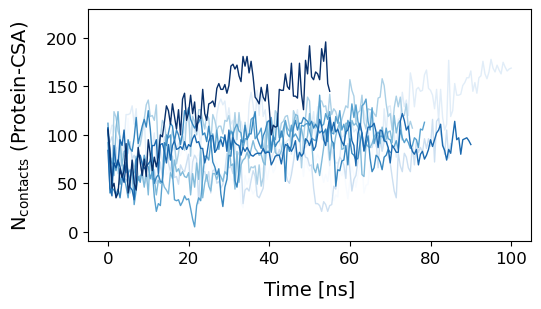

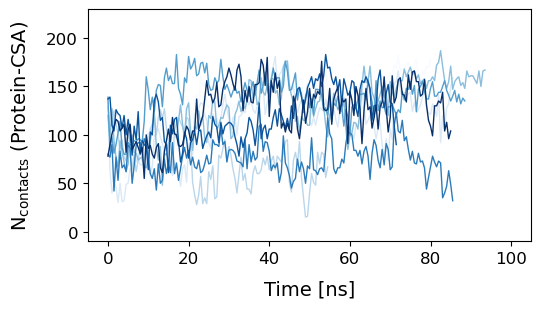

In [88]:
topdir = "./MD-dock-equil"
sites = ["dbl4-major-binding-site", "minor-binding-site"]

for i, site in enumerate(sites):
    site_dir = os.path.join(topdir, site)
    
    lst=[]
    replica = glob.glob(os.path.join(site_dir, 'cluster*.pdb+H'))

    for cnt, rep in enumerate(replica):
        data = os.path.join(rep, "prot-sug-contacts.xvg")
        arr = np.loadtxt(data, comments=["@","#"])
        
        df = pd.DataFrame()
        df["time"] = arr[::5,0]
        print(len(arr[:,0]))
        df["contacts"] = arr[::5,1]
        df["replica"] = cnt
        lst.append(df)
    
    df = pd.concat(lst)
    
    plt.figure(figsize=(8.27*2/3,3.2))
    
    ax = sns.lineplot(x='time', y='contacts', hue='replica', palette="Blues", data=df, linewidth = 1)
    ax.tick_params(labelsize=12)
    ax.set_ylim(-10,230) 
    ax.set_xlim(-5,105)
    ax.legend([],[], frameon=False)
    ax.set_xlabel(r"Time [ns]",fontsize=14, labelpad=10)  
    ax.set_ylabel(r"${\rm N_{contacts}}$ (Protein-CSA)",fontsize=14, labelpad=10) 
     
    plt.tight_layout()
    plt.savefig("/home/roessnra/Downloads/fig5-contacts_%s.svg" %site)

## Contacts between protein residues and docked sugar

In [ ]:
topdir = "./MD-dock-equil"

sites = ["dbl4-major-binding-site", "minor-binding-site"]

for site in sites:
    site_dir = os.path.join(topdir, site)
    
    arr_contacts = np.zeros(len(range(750,1931)))
    frames = 0
    replica = glob.glob(os.path.join(site_dir, 'cluster*.pdb+H'))
    for cnt, rep in enumerate(replica):
        print(cnt)
        u = mda.Universe(os.path.join(rep, 'dock-nvt_pp.gro'), os.path.join(rep, 'dock-run_pp.xtc'))

        sugar = u.select_atoms('(index 31313 to 31578) and not name H*') # docked sugar
        protein = u.select_atoms('protein and not name H* and (resid 750 to 1930)') # large part of n-teminal subunit is not relevant
        
        for ts in u.trajectory: 
            frames += 1 
            dist_arr = distances.distance_array(protein.positions, sugar.positions, box=u.dimensions)
         
            # group by resid
            df = pd.DataFrame(dist_arr)
            df["resid"] = protein.resids
            df_grouped = df.groupby('resid').aggregate('min')
            
            # get minimal distance of each residue to sugar
            df_grouped['min'] = df_grouped.min(axis=1)
            
            # assign contact when distance < 4.5 A
            df_grouped['contact'] = df_grouped['min'].apply(lambda x: 1 if x < 4.5 else 0)
            arr_contacts += np.array(df_grouped['contact'] ) 
    
    arr_percent = arr_contacts / frames
    
    arr = np.column_stack((np.array(range(750,1931)), arr_contacts))
    np.save(site + '-contacts.npy', arr)

## Figure S1:
Intra-domain RMSD.

In [5]:
# domains
subs = {
    "NTS" : [1,50],
    "DBL1X" : [51,377],
    "ID1" : [378,552],
    "DBL2X" : [553,960],
    "ID2a" : [961,1017],
    "ID2b" : [1018,1200],
    "DBL3X" : [1201,1529],
    "DBL4ε" : [1530,1921],
    "ID3" : [1922,1954]
}

In [ ]:
topdir = './MD-equil/'
for key, value in subs.items():
    diction = {
        "Time": [],
    }

    for i in range(1,11):
        rundir = topdir + str(i) + '/'

        # load universe
        u = mda.Universe(rundir + "run_pp.gro", rundir + "run_pp.xtc")
        u.trajectory[0]   # rewind trajectory

        sel = u.select_atoms("protein and resid %d-%d" %(value[0], value[1]))
        xref0 = sel.positions - sel.center_of_mass()

        time_list = []
        rmsd_list = []

        for ts in enumerate(u.trajectory):

            time = u.trajectory.time / 1000
            time_list.append(time)

            rmsd = mda.analysis.rms.rmsd(sel.positions, xref0, center=True, superposition=True) 
            rmsd_list.append(rmsd)

        # add to dictionary
        if i == 1:
            diction["Time"] = time_list

        diction[str(i)] = rmsd_list    

    rmsd = pd.DataFrame(diction)
    rmsd.to_pickle(topdir + "rmsd_%s" %key)

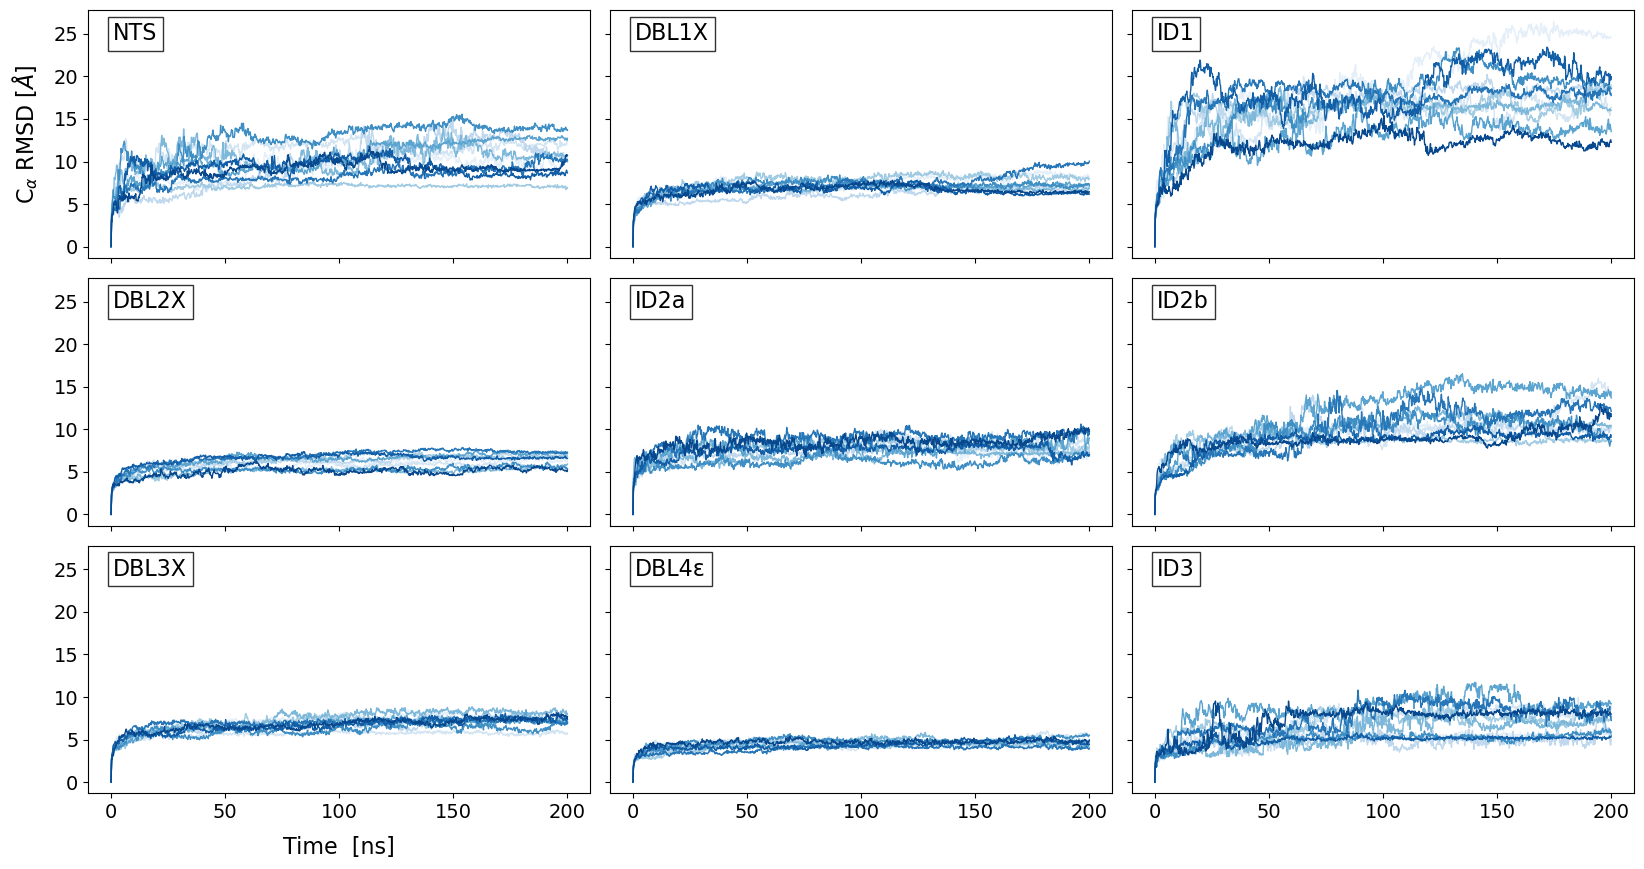

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(8.27*2,2.93*3), tight_layout=True, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

topdir = './MD-equil/'

cnt = 0
for key,value in subs.items():
    row = int(cnt/3)
    if cnt%3==0:
        ax = axes[row][0]
    elif cnt%3==1:
        ax = axes[row][1]   
    else:
        ax = axes[row][2]
    
    data = pd.read_pickle(topdir + "rmsd_%s" %key)
    sns.lineplot(x='Time', y='value', hue='variable', 
             data=pd.melt(data, ['Time']), linewidth = 1, palette = 'Blues', ax=ax)

    ax.text(0.05, 0.95, key, fontsize=16, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax.tick_params(labelsize=14)
    ax.legend([],[], frameon=False)
    
    cnt+=1

axes[2][0].set_xlabel(r"Time  [ns]",fontsize=16, labelpad=10)
axes[0][0].set_ylabel(ylabel = r"C$_\alpha$ RMSD [$\AA$]",fontsize=16, labelpad=10)
    
plt.savefig("/home/roessnra/Downloads/MD-rmsd-subunits.svg")

# Figure S2:
Inter-domain contacts.

In [ ]:
def count_contacts(selection1, selection2, dimensions, cutoff=4.5):
    """
    Count contacts between two selections in MDAnalysis.
    """
    # Calculate distances between atoms in selection1 and selection2
    distances = mda.analysis.distances.distance_array(selection1.positions, # reference
                                    selection2.positions, # configuration
                                    box=dimensions)
    
    # Count the number of rows with values smaller than the threshold
    count = np.sum(np.any(distances < cutoff, axis=1))
    return count   

In [ ]:
# generate matrix : which subdomains are in contact
topdir = './MD-equil/'

arr_contacts = np.zeros((len(subs), len(subs)))
for row_cnt, (row_key, row_value) in tqdm_notebook(enumerate(subs.items())):

    for i in range(1,11):
        rundir = topdir + str(i) + '/'

        # load universe
        u = mda.Universe(rundir + "run_pp.gro", rundir + "run_pp.xtc")
        u.trajectory[0]   # rewind trajectory

        row_sel = u.select_atoms("protein and resid %d-%d" %(row_value[0], row_value[1]))
        
        for col_cnt, (col_key, col_value) in enumerate(subs.items()):
            if col_key == row_key:
                continue
            col_sel = u.select_atoms("protein and resid %d-%d" %(col_value[0], col_value[1]))            
            
            arr_contacts[row_cnt, col_cnt] += count_contacts(row_sel, col_sel, dimensions=u.dimensions)

# average over 10 simulations
arr_contacts = arr_contacts/10
np.save(topdir + "domain_contacts.npy", arr_contacts)

In [ ]:
topdir = './MD-equil/'

fig, ax = plt.subplots(1, 1, figsize=(8.27*2/3,8.27*2/3), tight_layout=True, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.1)

arr = np.load(topdir + "domain_contacts.npy")
print(arr)
arr[arr < 2] = 0
arr[arr >= 2] = 1
mask = np.tril(np.ones_like(arr), k=0)
arr = arr * mask

colors = [(1, 1, 1), (0, 0, 1)]  # White (RGB: 255, 255, 255) to Blue (RGB: 0, 0, 255)
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

#cmap = sns.color_palette('blues', as_cmap=True)
heatmap = sns.heatmap(arr, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False, annot=False, ax=ax, linewidth=1, linecolor='white')

# ticks
xticks = range(len(subs))
yticks = range(len(subs))
ax.set_xticks([x+0.5 for x in xticks])
ax.set_yticks([x+0.5 for x in yticks])
ax.set_xticklabels(list(subs.keys()), rotation=45)
ax.set_yticklabels(list(subs.keys()))
ax.tick_params(labelsize=12)
plt.savefig("/home/roessnra/Downloads/MD-domain-contacts-overview.png")

Bash script: "domain_contacts.sh"
... iterating over 10 equilibration runs:
- generate index file with all domains
- compute contacts vs time for domain interfaces of interest

In [9]:
topdir = './MD-equil/'

fo = open(topdir + "domain_contacts.sh", 'w')
fo.write("""#!/bin/bash

indir=./MD-equil
outdir=$(echo $indir/domain_contacts)

mkdir $outdir
cd $indir
pwd


for run in {1..10}
do

    cd $run
    pwd
    { 
""")
fo.close()

# create index for subunits
for cnt, (key,values) in enumerate(subs.items()):
    with open(topdir + 'domain_contacts.sh', 'a') as file:
        file.write("    echo 1 \& r %d-%d\n" %(values[0], values[1]))
        file.write("    echo name %d %s\n" %((cnt+15), key))
        
fo = open(topdir + "domain_contacts.sh", 'a')
fo.write("""    echo q
    } | gmx make_ndx -f run_pp.gro -o tmp.ndx

""")
fo.close()

# get subunit interfaces of interest
arr = np.load(topdir + "domain_contacts.npy")

arr[arr < 2] = 0
arr[arr >= 2] = 1

# only keep values above diagonal
mask = np.triu(np.ones_like(arr), k=0)
arr = arr * mask

# get 2d array, 2 columns: row_index, col_index
row_indices, col_indices = np.where(arr == 1)
result = np.column_stack((row_indices, col_indices))

# mindist commands 
key_list = list(subs.keys())
for idx in result:
    idx_a = idx[0] + 15
    idx_b = idx[1] + 15
    
    name_a = key_list[idx[0]]
    name_b = key_list[idx[1]]
    
    with open(topdir + 'domain_contacts.sh', 'a') as file:
        file.write("    echo %d %d | gmx mindist -f run_pp.xtc -s run_pp.gro -n tmp.ndx -d 0.45 -dt 1 -group -tu ns -on $outdir/%s_%s_$run.xvg\n" %(idx_a, idx_b, name_a, name_b))

# go back to start directory and close for loop
fo = open(topdir + "domain_contacts.sh", 'a')
fo.write("""    
    rm \#*\#
    cd .. 
done
""")
fo.close()           

In [ ]:
!bash ./MD-equil/domain_contacts.sh

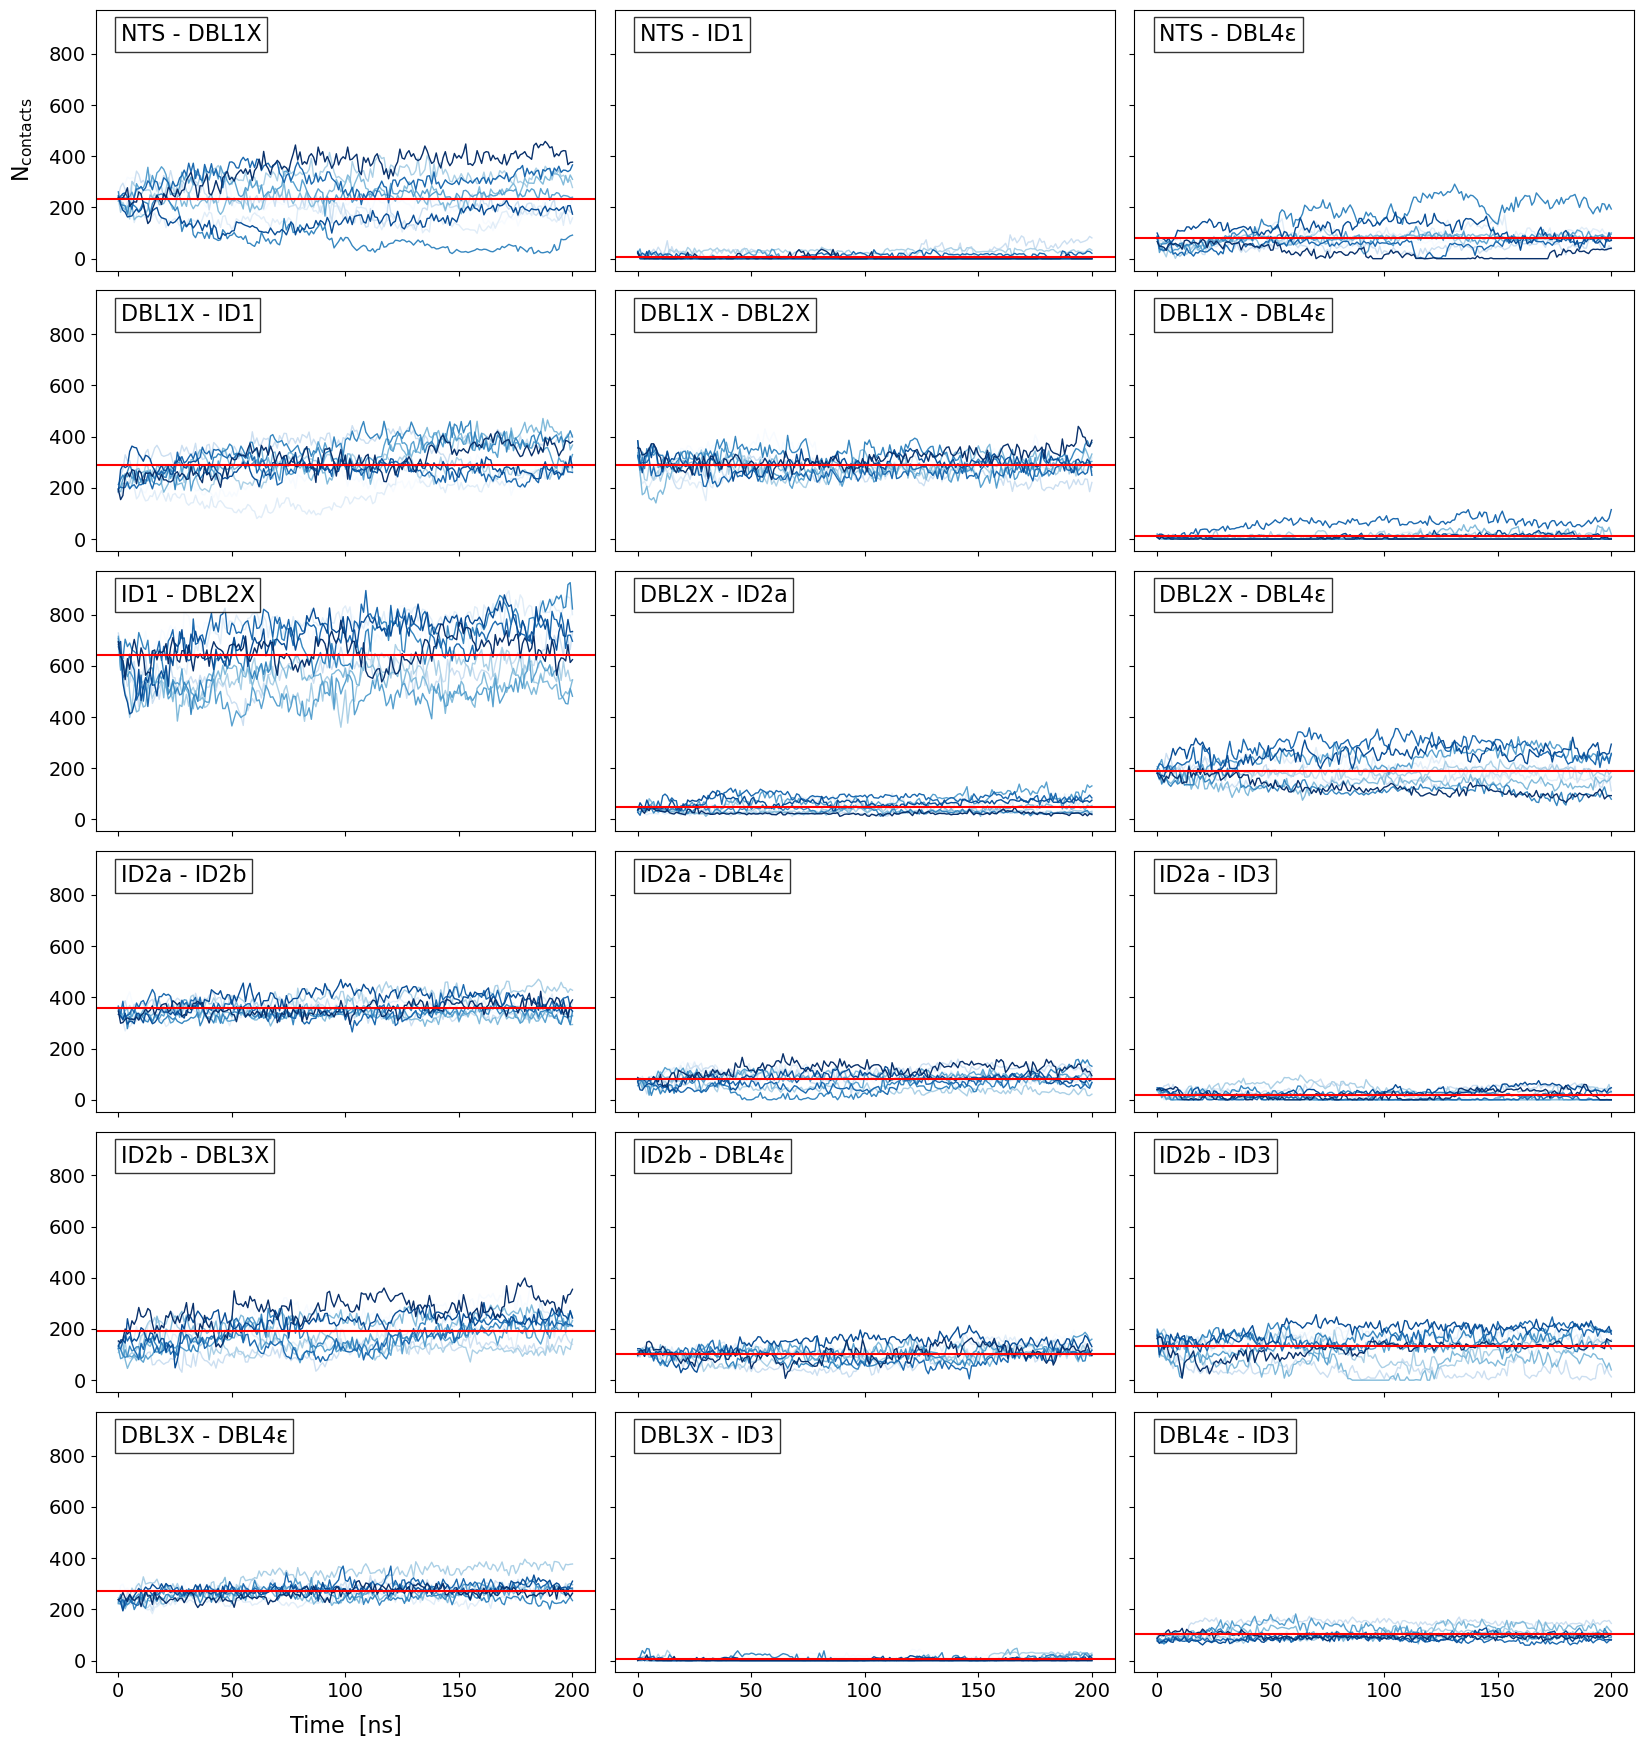

In [10]:
fig, axes = plt.subplots(6, 3, figsize=(8.27*2,2.93*6), tight_layout=True, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

topdir = './MD-equil/domain_contacts/'

# mindist commands 
key_list = list(subs.keys())
for cnt, idx in enumerate(result):
    
    row = int(cnt/3)
    if cnt%3==0:
        ax = axes[row][0]
    elif cnt%3==1:
        ax = axes[row][1]   
    else:
        ax = axes[row][2]
            
    name_a = key_list[idx[0]]
    name_b = key_list[idx[1]]
    
    lst=[]
    for run in range(1,11):
        data = np.loadtxt(topdir + "%s_%s_%d.xvg" %(name_a, name_b, run), comments=['#','@'])  
        
        df = pd.DataFrame()
        df['Time'] = data[:,0]
        df['Contacts'] = data[:,1]
        df['Run'] = run
        lst.append(df)
        
    df = pd.concat(lst)
    sns.lineplot(df, x='Time', y='Contacts', hue='Run', linewidth = 1, palette = 'Blues', ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")

    title = name_a + ' - ' + name_b
    ax.text(0.05, 0.95, title, fontsize=16, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

    ax.tick_params(labelsize=14)
    ax.legend([],[], frameon=False)
    ax.axhline(y=np.mean(df['Contacts']), color='red')
    
axes[5][0].set_xlabel(r"Time  [ns]",fontsize=16, labelpad=10)
axes[0][0].set_ylabel(ylabel = r"${\rm N_{contacts}}$",fontsize=16, labelpad=10)
    
plt.savefig("/home/roessnra/Downloads/MD-domain-contacts.svg")